In [1]:
import numpy as np
import random
from numpy import linalg as LA
from sklearn.preprocessing import normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *

## parameter setup

In [2]:
n_samples = 100
dim = 10
k = 2
sig_noise = 0.01
beta_reg = 0.1
T = 2000
Runs = 3

## generate ground truth x_true

In [3]:
x_true = np.zeros((dim, 1))
J_start = 0
x_true[J_start:J_start+k]=1.0
S_opt = [*range(J_start, J_start+k)]

## generate data

In [4]:
A_list = []
y_list = []
x_init_list = []

for idx in range(T):
    A = np.random.randn(n_samples, dim)
    Ax_true = A @ x_true
    noise = sig_noise*np.random.randn(n_samples, 1)
    y = Ax_true + noise
    A_list.append(A.copy())
    y_list.append(y.copy())
    x_iter = np.random.rand(dim, 1) * 1.0 
    x_iter = np.clip(x_iter, 0.0, 1.0)
    x_init_list.append(x_iter)

## OGDA

In [5]:
def ogd_online(Runs, A_list, y_list, x_init_list, lr, T, beta_reg, S_opt):
    estimation_error_run_list = []

    for run_idx in range(Runs):
        x_iter = x_init_list[run_idx].copy()
        best_value = 100000.0
        estimation_errors = []
        
        dim_x = x_iter.shape[0]
        for iter_t in tqdm(range(T)):
            S_t, S_t_index = sample_S_t(x_iter)
            F_grads, G_grads, H_vals = compute_subgrad(x_iter, A_list[iter_t], y_list[iter_t], beta_reg)
            g_t = beta_reg * F_grads - G_grads

            x_iter = x_iter - lr * g_t
            x_iter = np.clip(x_iter, 0.0, 1.0)

            estimation_errors.append(LA.norm(x_iter-x_true))
        estimation_error_run_list.append(estimation_errors)
        
    return estimation_error_run_list

## Running with different learning rates

In [6]:
for constant in [1.0, 5.0, 10.0]:
    lr=np.sqrt(dim) / (constant * np.sqrt(T))
    print('lr=eta/{}'.format(constant))
    estimation_error_run_list = ogd_online(Runs, A_list, y_list, x_init_list, lr, T, beta_reg, S_opt)
    estimation_error_avg = np.mean(np.array(estimation_error_run_list), axis=0)
    np.save('estimation_error_lr_constant{}.npy'.format(constant), estimation_error_avg)

lr=eta/1.0


100%|██████████| 2000/2000 [00:02<00:00, 985.65it/s]


lr=eta/5.0


100%|██████████| 2000/2000 [00:01<00:00, 1101.16it/s]


lr=eta/10.0


100%|██████████| 2000/2000 [00:01<00:00, 1100.57it/s]


## Visualize

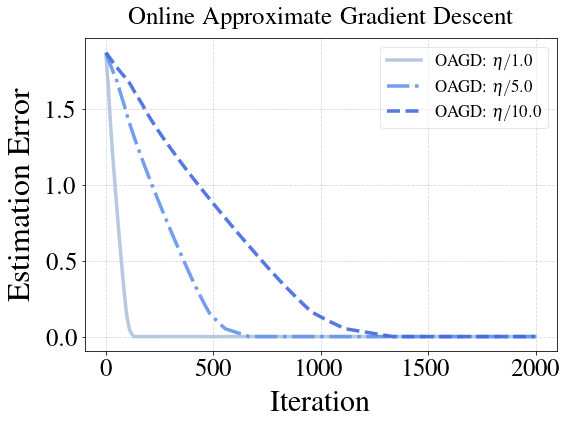

In [7]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting

plt.rcParams.update({
  "text.usetex": True,
  "font.serif" : "times",
  "font.family": "serif"
})

color_list = ['lightsteelblue', 'cornflowerblue', 'royalblue', 'darkblue']
line_style_list = ['-', '-.', '--', ':']
idx_plot = 0

for constant in [1.0, 5.0, 10.0]:
    estimation_error_avg = np.load('estimation_error_lr_constant{}.npy'.format(constant))
    plt.plot(range(T), estimation_error_avg,
             ls=line_style_list[idx_plot],
             linewidth=3.5,
             alpha=0.9,
             label="OAGD: $\eta/{}$".format(constant),
             color = color_list[idx_plot],
            )
    idx_plot += 1


plt.legend(fontsize='17', framealpha=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.8, alpha=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.title("Online Approximate Gradient Descent", fontsize='25', pad=15)


plt.xlabel("Iteration", fontsize='30', labelpad=10)
plt.ylabel("Estimation Error", fontsize='32', labelpad=10)

plt.tight_layout()